<a href="https://colab.research.google.com/github/Stefi96/DetectingNFTs-Master/blob/main/Domains_NFT_Master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [124]:
# @title Lets import the libraries and code
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import lightgbm as lgb

In [125]:
# Load the  uploaded datasets
scam_data = pd.read_csv('/content/drive/MyDrive/Master/Project/Domains/final_blocklist_domains.csv')
legit_data = pd.read_csv('/content/drive/MyDrive/Master/Project/Domains/final_legit_domains.csv')
# Load data localy
# scam_data = pd.read_csv(r'C:\Users\stefanve\Desktop\Project\Domains\final_blocklist_domains.csv')
# legit_data = pd.read_csv(r"C:\Users\stefanve\Desktop\Project\Domains\final_legit_domains.csv")

In [126]:
# Display the first few rows of each dataset for verification
scam_data.head(), legit_data.head()

(                   url
 0  blogpost-opensea.io
 1       phantomweb.app
 2           aurory.app
 3         solvision.io
 4        staratlas.art,
              Unique Domains
 0             basis.markets
 1          skeletoncrew.rip
 2              flippies.art
 3  meerkatmillionaires.club
 4           stylishstuds.io)

In [127]:
# label the data
scam_data['label'] = 1
legit_data['label'] = 0

# Renaming the 'Unique Domains' column in legit dataset to 'url'
legit_data.rename(columns={"Unique Domains": "url"}, inplace=True)

# Combine the datasets
combined_data = pd.concat([scam_data, legit_data], ignore_index=True)

# Display the first few rows of the combined dataset
combined_data.head()

,url,label
0,blogpost-opensea.io,1
1,phantomweb.app,1
2,aurory.app,1
3,solvision.io,1
4,staratlas.art,1


In [128]:
# Check for missing values
combined_data.isna().sum()

# Fill NaN with placeholder
combined_data['url'] = combined_data['url'].fillna("missing")

# Drop NA
#combined_data = combined_data.dropna()

In [129]:
combined_data['url']

0           blogpost-opensea.io
1                phantomweb.app
2                    aurory.app
3                  solvision.io
4                 staratlas.art
                 ...           
2446                 koinkoi.io
2447            burritoboyz.wtf
2448                   t00b.app
2449            outcast.academy
2450    apesofwallstreetnft.com
Name: url, Length: 2451, dtype: object

In [130]:
# # Convert the 'url' column to string
# combined_data['url'] = combined_data['url'].astype(str)

In [131]:
# Label encoding the URLs
label_encoder = LabelEncoder()
combined_data['url_encoded'] = label_encoder.fit_transform(combined_data['url'])

In [132]:
# Extracting features from the URLs
combined_data['domain_length'] = combined_data['url'].apply(lambda x: len(x))
combined_data['num_special_chars'] = combined_data['url'].apply(lambda x: sum([1 for char in x if not char.isalnum()]))
combined_data['num_subdomains'] = combined_data['url'].apply(lambda x: x.count('.'))
combined_data['has_http'] = combined_data['url'].apply(lambda x: 1 if 'http' in x else 0)
combined_data['has_https'] = combined_data['url'].apply(lambda x: 1 if 'https' in x else 0)
combined_data['has_www'] = combined_data['url'].apply(lambda x: 1 if 'www' in x else 0)
combined_data['has_numbers'] = combined_data['url'].apply(lambda x: 1 if any(char.isdigit() for char in x) else 0)

In [133]:
combined_data

,url,label,url_encoded,domain_length,num_special_chars,num_subdomains,has_http,has_https,has_www,has_numbers
0,blogpost-opensea.io,1,184,19,2,1,0,0,0,0
1,phantomweb.app,1,1422,14,1,1,0,0,0,0
2,aurory.app,1,133,10,1,1,0,0,0,0
3,solvision.io,1,2101,12,1,1,0,0,0,0
4,staratlas.art,1,2130,13,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2446,koinkoi.io,0,801,10,1,1,0,0,0,0
2447,burritoboyz.wtf,0,267,15,1,1,0,0,0,0
2448,t00b.app,0,2180,8,1,1,0,0,0,1
2449,outcast.academy,0,1337,15,1,1,0,0,0,0


In [134]:
# TF-IDF Tokenization
tfidf_vectorizer = TfidfVectorizer(max_features=100)
url_tfidf = tfidf_vectorizer.fit_transform(combined_data['url'])
url_tfidf_df = pd.DataFrame(url_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
combined_data_2 = pd.concat([combined_data, url_tfidf_df], axis=1)

combined_data_2.drop(columns=['url'], inplace=True)

combined_data_2.head()

,label,url_encoded,domain_length,num_special_chars,num_subdomains,has_http,has_https,has_www,has_numbers,alpha,...,uno,v2,web,website,work,world,xyz,y00ts,yoots,zerium
0,1,184,19,2,1,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1422,14,1,1,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,133,10,1,1,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2101,12,1,1,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,2130,13,1,1,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
# Splitting the data
X = combined_data_2.drop("label", axis=1)
y = combined_data_2["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # maybe without stratify

In [136]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_metrics = (accuracy_score(y_test, rf_predictions), precision_score(y_test, rf_predictions), recall_score(y_test, rf_predictions), f1_score(y_test, rf_predictions))

rf_metrics

(0.8024439918533605,
 0.8484848484848485,
 0.8562691131498471,
 0.8523592085235921)

In [137]:
# Hyperparameter tuning for RandomForest
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf_clf = grid_search.best_estimator_
y_pred_best_rf = best_rf_clf.predict(X_test)

accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
precision_best_rf = precision_score(y_test, y_pred_best_rf)
recall_best_rf = recall_score(y_test, y_pred_best_rf)
f1_best_rf = f1_score(y_test, y_pred_best_rf)

print("Tuned RandomForest Results:", accuracy_best_rf, precision_best_rf, recall_best_rf, f1_best_rf)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Tuned RandomForest Results: 0.8207739307535642 0.8699690402476781 0.8593272171253823 0.8646153846153847


In [138]:
# Random forrest with bagging
bagging_clf = BaggingClassifier(estimator=RandomForestClassifier(n_estimators=100, random_state=42),
                                n_estimators=10, random_state=42)
bagging_clf.fit(X_train, y_train)

# Predictions
y_pred_bagging = bagging_clf.predict(X_test)

# Evaluation
accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
precision_bagging = precision_score(y_test, y_pred_bagging)
recall_bagging = recall_score(y_test, y_pred_bagging)
f1_bagging = f1_score(y_test, y_pred_bagging)

print("Accuracy:", accuracy_bagging)
print("Precision:", precision_bagging)
print("Recall:", recall_bagging)
print("F1-Score:", f1_bagging)

Accuracy: 0.8207739307535642
Precision: 0.8632218844984803
Recall: 0.8685015290519877
F1-Score: 0.8658536585365854


In [139]:
# Random Forest with TF-IDF
rf_clf_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf_tfidf.fit(X_train, y_train)
y_pred_rf_tfidf = rf_clf_tfidf.predict(X_test)
accuracy_rf_tfidf = accuracy_score(y_test, y_pred_rf_tfidf)
precision_rf_tfidf = precision_score(y_test, y_pred_rf_tfidf)
recall_rf_tfidf = recall_score(y_test, y_pred_rf_tfidf)
f1_rf_tfidf = f1_score(y_test, y_pred_rf_tfidf)

print("Random Forest with TF-IDF Metrics:")
print("Accuracy:", accuracy_rf_tfidf)
print("Precision:", precision_rf_tfidf)
print("Recall:", recall_rf_tfidf)
print("F1-Score:", f1_rf_tfidf)

Random Forest with TF-IDF Metrics:
Accuracy: 0.8024439918533605
Precision: 0.8484848484848485
Recall: 0.8562691131498471
F1-Score: 0.8523592085235921


In [140]:
# Random forrest with SMOTE balancer
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Training Random Forest on the SMOTE balanced data
rf_clf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf_smote.fit(X_train_smote, y_train_smote)

# Predictions
y_pred_rf_smote = rf_clf_smote.predict(X_test)

# Evaluation
accuracy_rf_smote = accuracy_score(y_test, y_pred_rf_smote)
precision_rf_smote = precision_score(y_test, y_pred_rf_smote)
recall_rf_smote = recall_score(y_test, y_pred_rf_smote)
f1_rf_smote = f1_score(y_test, y_pred_rf_smote)

accuracy_rf_smote, precision_rf_smote, recall_rf_smote, f1_rf_smote

(0.7820773930753564, 0.8459119496855346, 0.8226299694189603, 0.834108527131783)

In [141]:
# Initializing the LightGBM model
lgbm_model = lgb.LGBMClassifier(objective='binary', class_weight='balanced', random_state=42)

# Training the model
lgbm_model.fit(X_train, y_train)

# Predictions
y_pred_lgbm = lgbm_model.predict(X_test)

# Evaluation
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
precision_lgbm = precision_score(y_test, y_pred_lgbm)
recall_lgbm = recall_score(y_test, y_pred_lgbm)
f1_lgbm = f1_score(y_test, y_pred_lgbm)

accuracy_lgbm, precision_lgbm, recall_lgbm, f1_lgbm

[LightGBM] [Info] Number of positive: 1303, number of negative: 657
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 446
[LightGBM] [Info] Number of data points in the train set: 1960, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


(0.790224032586558, 0.8943661971830986, 0.7767584097859327, 0.8314238952536824)

In [142]:
# XGBoost
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_metrics = (accuracy_score(y_test, xgb_predictions), precision_score(y_test, xgb_predictions), recall_score(y_test, xgb_predictions), f1_score(y_test, xgb_predictions))

xgb_metrics

(0.845213849287169, 0.8885448916408669, 0.8776758409785933, 0.8830769230769231)

In [143]:
# SVM
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)
svm_metrics = (accuracy_score(y_test, svm_predictions), precision_score(y_test, svm_predictions), recall_score(y_test, svm_predictions), f1_score(y_test, svm_predictions))

svm_metrics

(0.7718940936863544,
 0.7654320987654321,
 0.9480122324159022,
 0.8469945355191256)

In [144]:
# Ensemble Method (RF + SVM)
ensemble_predictions = (rf_model.predict_proba(X_test)[:, 1] + svm_model.predict_proba(X_test)[:, 1]) / 2
ensemble_final_predictions = [1 if prob > 0.5 else 0 for prob in ensemble_predictions]

In [145]:
ensemble_metrics = (accuracy_score(y_test, ensemble_final_predictions), precision_score(y_test, ensemble_final_predictions), recall_score(y_test, ensemble_final_predictions), f1_score(y_test, ensemble_final_predictions))

ensemble_metrics

(0.8024439918533605,
 0.8362573099415205,
 0.8746177370030581,
 0.8550074738415546)

In [146]:
# # Anomaly detection, poor results
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.ensemble import IsolationForest
# from sklearn.metrics import classification_report

# # Reload the datasets
# scam_df = pd.read_csv('/content/drive/MyDrive/Master/Project/Domains/final_blocklist_domains.csv')
# legit_df = pd.read_csv('/content/drive/MyDrive/Master/Project/Domains/final_legit_domains.csv')

# # Split the legitimate URLs for training and testing
# legit_train, legit_test = train_test_split(legit_df, test_size=0.2, random_state=42)

# # For anomaly detection, we'll train on the legit_train set and test on both legit_test and scam_df
# X_train = legit_train['Unique Domains'].fillna("")
# X_test = pd.concat([legit_test['Unique Domains'].fillna(""), scam_df['url'].fillna("")])

# # Labels for evaluation
# y_test = [0] * len(legit_test) + [1] * len(scam_df)

# # Convert the URL strings to a format suitable for the model using TF-IDF
# tfidf_vectorizer_anomaly = TfidfVectorizer(ngram_range=(1, 2), max_features=100)
# X_train_tfidf = tfidf_vectorizer_anomaly.fit_transform(X_train).toarray()  # Convert to array format
# X_test_tfidf = tfidf_vectorizer_anomaly.transform(X_test).toarray()  # Convert to array format

# # Train the Isolation Forest model
# iso_forest = IsolationForest(contamination=0.05, random_state=42)
# iso_forest.fit(X_train_tfidf)

# # Predict on the test set
# predictions = [-1 if x == 1 else 1 for x in iso_forest.predict(X_test_tfidf)]

# # Evaluate the model
# report = classification_report(y_test, predictions)

# report


In [147]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. Tokenize and convert URLs to sequences
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(combined_data['url'])
sequences = tokenizer.texts_to_sequences(combined_data['url'])

# 2. Find the max length of sequences and pad
max_length = max([len(seq) for seq in sequences])
X_padded = pad_sequences(sequences, maxlen=max_length)

In [148]:
# 3. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, combined_data['label'], test_size=0.2, random_state=42)

# 4. Build and train the RNN model
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [149]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=32, input_length=max_length))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [150]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
62/62 [==============================] - 10s 74ms/step - loss: 0.6260 - accuracy: 0.6541 - val_loss: 0.5541 - val_accuracy: 0.7006
Epoch 2/10
62/62 [==============================] - 4s 70ms/step - loss: 0.5637 - accuracy: 0.6878 - val_loss: 0.5105 - val_accuracy: 0.7210
Epoch 3/10
62/62 [==============================] - 3s 50ms/step - loss: 0.5324 - accuracy: 0.7255 - val_loss: 0.4848 - val_accuracy: 0.7658
Epoch 4/10
62/62 [==============================] - 3s 47ms/step - loss: 0.5115 - accuracy: 0.7469 - val_loss: 0.5057 - val_accuracy: 0.7352
Epoch 5/10
62/62 [==============================] - 3s 45ms/step - loss: 0.4888 - accuracy: 0.7582 - val_loss: 0.4680 - val_accuracy: 0.7719
Epoch 6/10
62/62 [==============================] - 3s 52ms/step - loss: 0.4844 - accuracy: 0.7607 - val_loss: 0.4651 - val_accuracy: 0.7821
Epoch 7/10
62/62 [==============================] - 4s 68ms/step - loss: 0.4641 - accuracy: 0.7755 - val_loss: 0.4594 - val_accuracy: 0.7943
Epoch 8/10
6

In [151]:
# Return the final training accuracy and validation accuracy
history.history['accuracy'][-1], history.history['val_accuracy'][-1]

(0.7928571701049805, 0.771894097328186)

In [152]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

16/16 [==============================] - 0s 13ms/step - loss: 0.4623 - accuracy: 0.7719
Test Accuracy: 77.19%


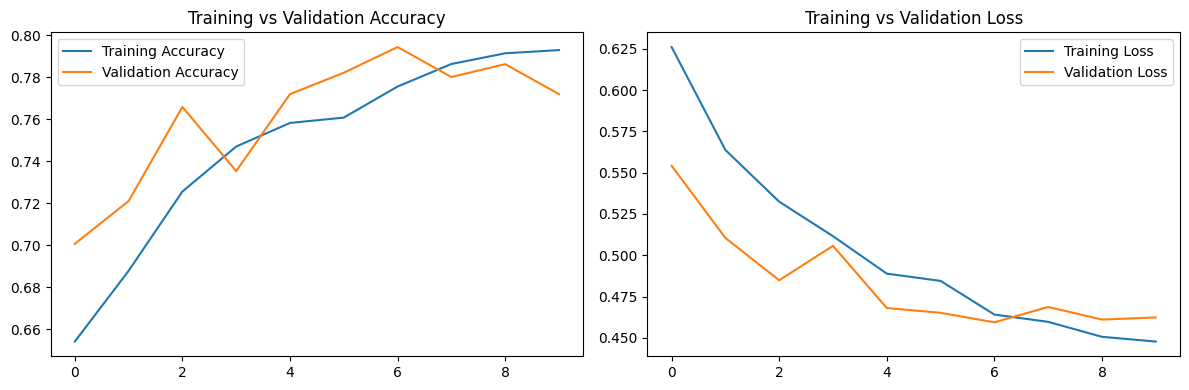

In [153]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Plotting training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.tight_layout()
plt.show()

In [ ]:
def classify_url(model, tokenizer, url, max_length=108):
    # Tokenize the URL
    sequence = tokenizer.texts_to_sequences([url])

    # Pad the tokenized URL
    padded_sequence = pad_sequences(sequence, maxlen=max_length)

    # Predict using the model
    prediction = model.predict(padded_sequence)[0][0]

    # Classify based on the prediction
    if prediction >= 0.5:
        return "Scam"
    else:
        return "Legit"

# Example
new_url = "partydegens.io"
result = classify_url(history, tokenizer, new_url)
print(f"The URL {new_url} is classified as {result}.")
